# AllLife Credit Card Customer Segmentation

## Objective:

### To identify different customer segments based on their spending patterns as well as past interaction with the bank.

## Key Questions:

### 1. How many different segments of customers are there?
### 2. How are these segments different from each other?
### 3. What are your recommendations to the bank on how to better market to and service these customers?

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist # To show pairwise distances between data point

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.decomposition import PCA

C:\Users\William\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Reading dataset file

data = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
# Dropping 'Sl_No' and 'Customer Key' as they are not relevant

data.drop(['Sl_No', 'Customer Key'], inplace=True, axis=1)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [7]:
data.skew()

Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

In [8]:
# Finding number of outliers in dataset
from scipy import stats

z = np.abs(stats.zscore(data))
print(z)

outliers = data.copy()

outliers = outliers[(z < 3).all(axis=1)]

print(data.shape)
print(outliers.shape)

[[1.74018685 1.24922476 0.86045063 0.54748969 1.25153737]
 [0.41029254 0.78758515 1.47373077 2.5205186  1.89185881]
 [0.41029254 1.05897329 0.86045063 0.13428993 0.1455276 ]
 ...
 [2.93709172 1.5206129  0.86045063 2.17962879 0.90227113]
 [3.65523464 2.44389211 0.86045063 4.22496765 1.25153737]
 [3.52224521 1.9822525  1.47373077 3.20229822 0.55300488]]
(660, 5)
(625, 5)


In [9]:
# Avg_Credit_Limit and Total_visits_online are highly positively skewed

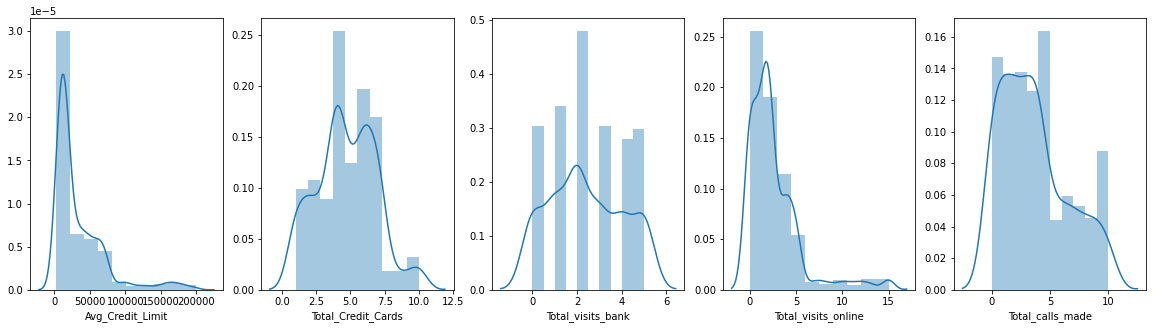

In [10]:
# Using seaborn distplot to analyze distribution of columns

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
vis1 = sb.distplot(data['Avg_Credit_Limit'], bins=10, ax=ax[0])
vis2 = sb.distplot(data['Total_Credit_Cards'], bins=10, ax=ax[1])
vis3 = sb.distplot(data['Total_visits_bank'], bins=10, ax=ax[2])
vis4 = sb.distplot(data['Total_visits_online'], bins=10, ax=ax[3])
vis5 = sb.distplot(data['Total_calls_made'], bins=10, ax=ax[4])
fig.savefig('subplot.png')

<AxesSubplot:>

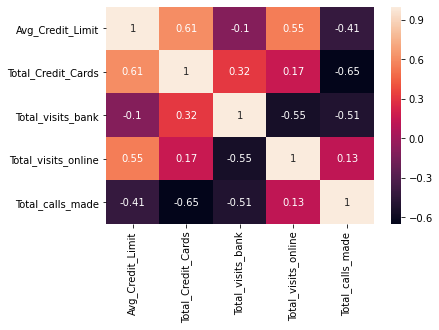

In [11]:
# Displaying correlation heatmap

sb.heatmap(data.corr(), annot=True)

### Business insights:

No significant correlation apparent among the features.

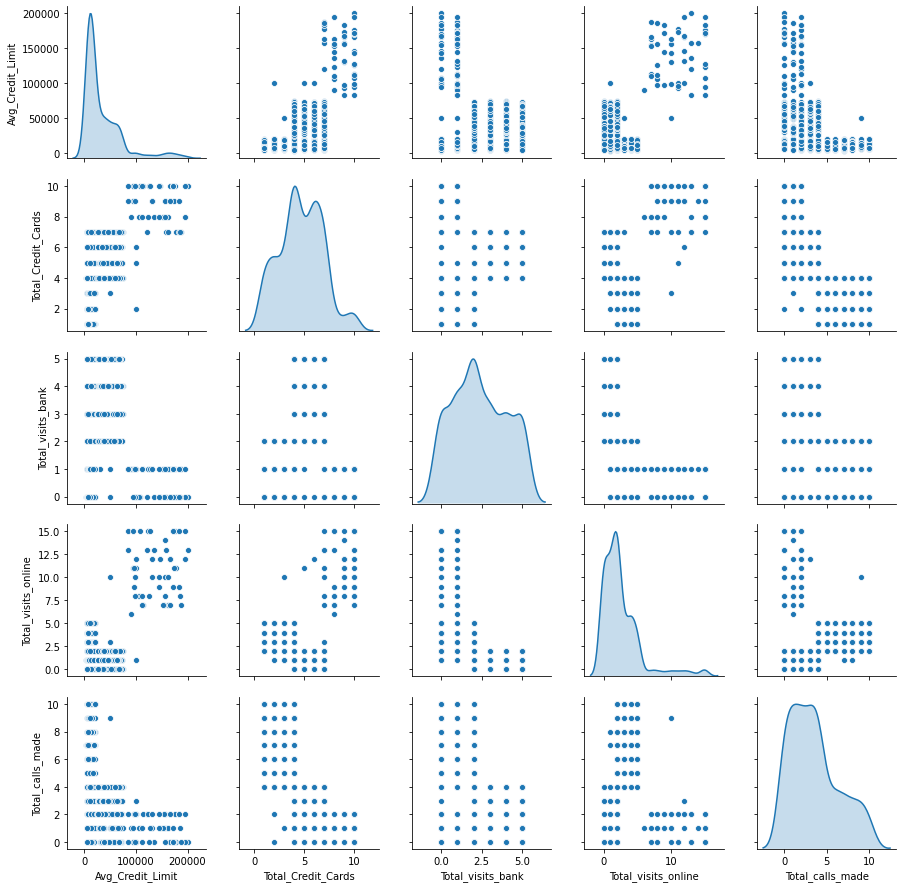

In [12]:
# Displaying pairplot visualizations

sb.pairplot(data, diag_kind='kde')

According to this pairplot, looking at the distribution curves along the diagonal, we can expect the ideal number of clusters to be between 2 and 3.

Average Credit Limit and Total Visits online are both positively skewed, so we can assume that customers with a credit limit of 100,000 or higher typically bank online more frequently than those with a credit limit lower than 100,000.

In [13]:
# Scaling the data
from scipy.stats import zscore

data = data.apply(zscore)

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,8.195465e-16,1.000758,-0.839808,-0.653623,-0.440840,0.357097,4.399975
Total_Credit_Cards,660.0,-4.006223e-15,1.000758,-1.710864,-0.787585,0.135694,0.597334,2.443892
Total_visits_bank,660.0,1.157323e-16,1.000758,-1.473731,-0.860451,-0.247170,0.979390,1.592670
Total_visits_online,660.0,1.944572e-16,1.000758,-0.888380,-0.547490,-0.206600,0.475180,4.224968
Total_calls_made,660.0,-7.112156e-16,1.000758,-1.251537,-0.902271,-0.203739,0.494794,2.241125


## K-means Clustering

Text(0.5, 1.0, 'Selecting k with the elbow method')

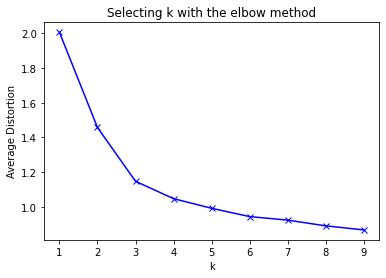

In [15]:
# Finding optimal number of clusters

from scipy.spatial.distance import cdist
clusters=range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data)
    prediction = model.predict(data)
    meanDistortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the elbow method')

### According to the elbow method, the ideal value of k would be 3.

In [16]:
# Setting value of k = 3

kmeans = KMeans(n_clusters = 3, n_init = 15, random_state = 1)

In [17]:
kmeans.fit(data)

KMeans(n_clusters=3, n_init=15, random_state=1)

In [18]:
centroids = kmeans.cluster_centers_

In [19]:
centroids

array([[-0.59579625, -1.05962278, -0.9015185 ,  0.32299678,  1.14810882],
       [-0.02106178,  0.37368962,  0.6663945 , -0.55367163, -0.55300488],
       [ 2.83176409,  1.86222621, -1.10576269,  2.82731942, -0.87432983]])

In [20]:
# Calculating centroids for the columns

centroid_data = pd.DataFrame(centroids, columns = list(data))

In [21]:
centroid_data

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.595796,-1.059623,-0.901518,0.322997,1.148109
1,-0.021062,0.373690,0.666395,-0.553672,-0.553005
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [22]:
# Creating dataframe for labels and converting labels into a categorical variable

data_labels = pd.DataFrame(kmeans.labels_, columns = list(['labels']))

data_labels['labels'] = data_labels['labels'].astype('category')

In [23]:
# Joining labeled dataframe with dataframe
data_labeled = data.join(data_labels)

In [24]:
# Analyzing labeled data with groupby

data_analysis = data_labeled.groupby(['labels'], axis = 0)

In [25]:
data_analysis.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,1
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,0
2,0.410293,1.058973,-0.860451,0.134290,0.145528,1
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,1
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593,0
6,1.740187,0.135694,-1.473731,2.861408,-0.553005,2
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271,0
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005,0
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326,0


In [26]:
data_labeled['labels'].value_counts()

1    386
0    224
2     50
Name: labels, dtype: int64

Text(0.5, 0.92, '3D Plot of KMeans Clustering')

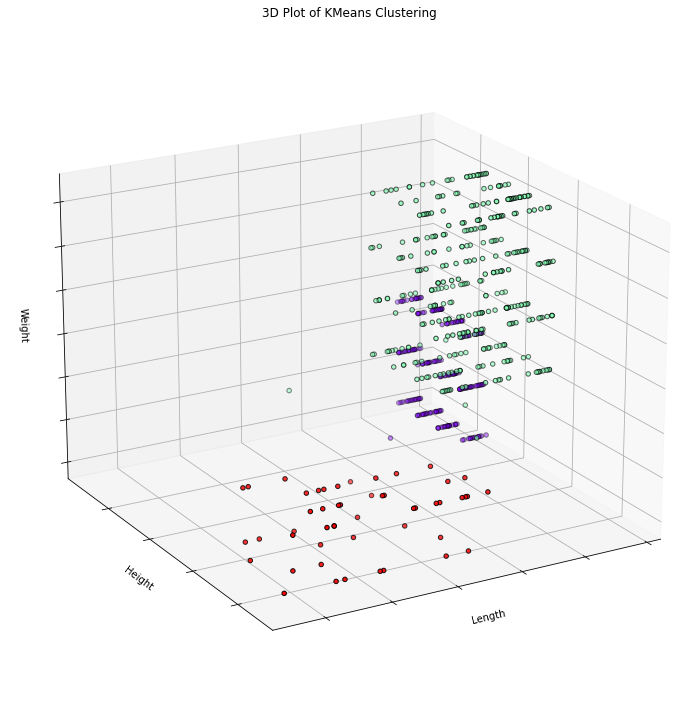

In [27]:
# 3D plots of clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev = 20, azim = 60)
labels = kmeans.labels_
ax.scatter(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], c = labels.astype(np.float), edgecolor = 'k', cmap='rainbow')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D Plot of KMeans Clustering')

In [28]:
# Final cluster prediction

final_model = KMeans(3)
final_model.fit(data)
prediction = final_model.predict(data)

# Appending prediction

data['CLUSTER'] = prediction

data

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,CLUSTER
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,1
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2
...,...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537,2
656,1.314621,2.443892,-0.860451,3.543188,-0.553005,2
657,2.937092,1.520613,-0.860451,2.179629,-0.902271,2
658,3.655235,2.443892,-0.860451,4.224968,-1.251537,2


In [29]:
Kmeans_clusters = data.groupby(['CLUSTER'])

Kmeans_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
CLUSTER,,,,,
0,-0.021062,0.373690,0.666395,-0.553672,-0.553005
1,-0.595796,-1.059623,-0.901518,0.322997,1.148109
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[CLUSTER]'>],
       [<AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[CLUSTER]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:>]], dtype=object)

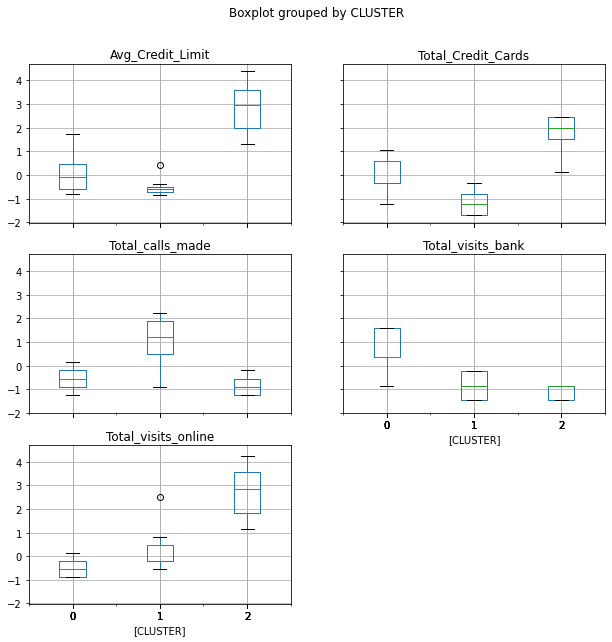

In [30]:
data.boxplot(by = 'CLUSTER', figsize=(10, 10))

## Hierarchical Clustering

In [31]:
# Creating agglomerative clustering model

model = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')

model.fit(data)

data_agg = data.copy()

data_agg.drop('CLUSTER', inplace = True, axis = 1)

data_agg['CLUSTER'] = model.labels_

data_agg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,CLUSTER
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1


In [32]:
H_clusters = data_agg.groupby(['CLUSTER'])

In [33]:
H_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
CLUSTER,,,,,
0,-0.021062,0.373690,0.666395,-0.553672,-0.553005
1,2.831764,1.862226,-1.105763,2.827319,-0.874330
2,-0.595796,-1.059623,-0.901518,0.322997,1.148109


In [44]:
Kmeans_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
CLUSTER,,,,,
0,-0.021062,0.373690,0.666395,-0.553672,-0.553005
1,-0.595796,-1.059623,-0.901518,0.322997,1.148109
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


Comparing the KMeans and Hierarchical, 

In [34]:
# Cophenetic correlation for average linkage

Z = linkage(data_agg, metric = 'euclidean', method = 'average')

c_average, coph_dists = cophenet(Z, pdist(data))

c_average

0.9048635638629935

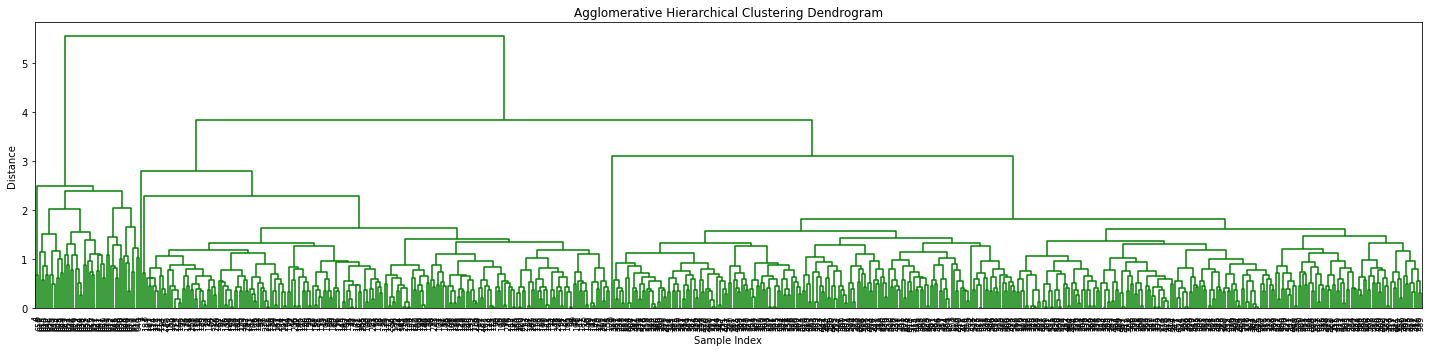

In [35]:
# Dendrogram

plt.figure(figsize = (20, 5))
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90, color_threshold = 40, leaf_font_size = 8)
plt.tight_layout()

In [36]:
# Cophenetic correlation for complete linkage

Z = linkage(data, metric = 'euclidean', method = 'complete')

c_complete, coph_dists = cophenet(Z, pdist(data))

c_complete

0.8860521900934342

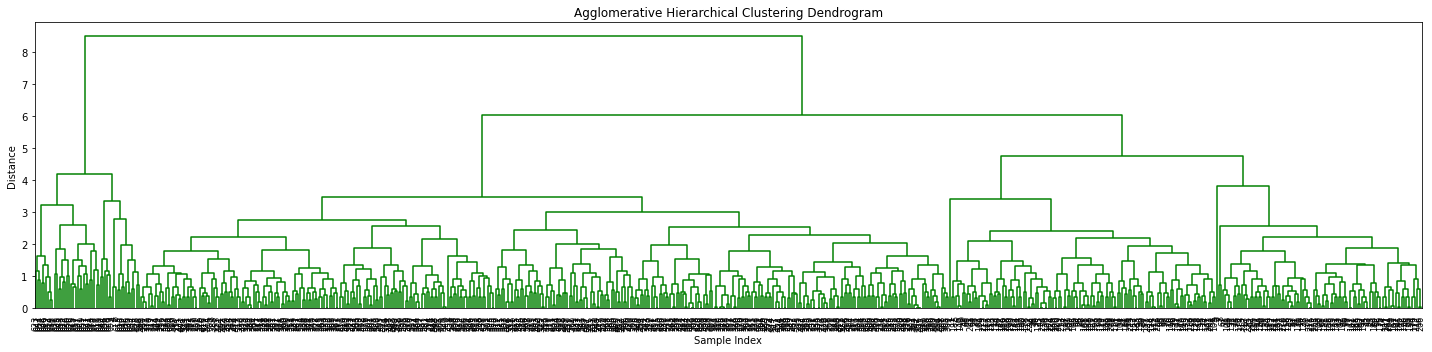

In [37]:
# Dendrogram

plt.figure(figsize = (20, 5))
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90, color_threshold = 40, leaf_font_size = 8)
plt.tight_layout()

In [38]:
# Cophenetic correlation for ward linkage

Z = linkage(data, metric = 'euclidean', method = 'ward')

c_ward, coph_dists = cophenet(Z, pdist(data))

c_ward

0.774233615737438

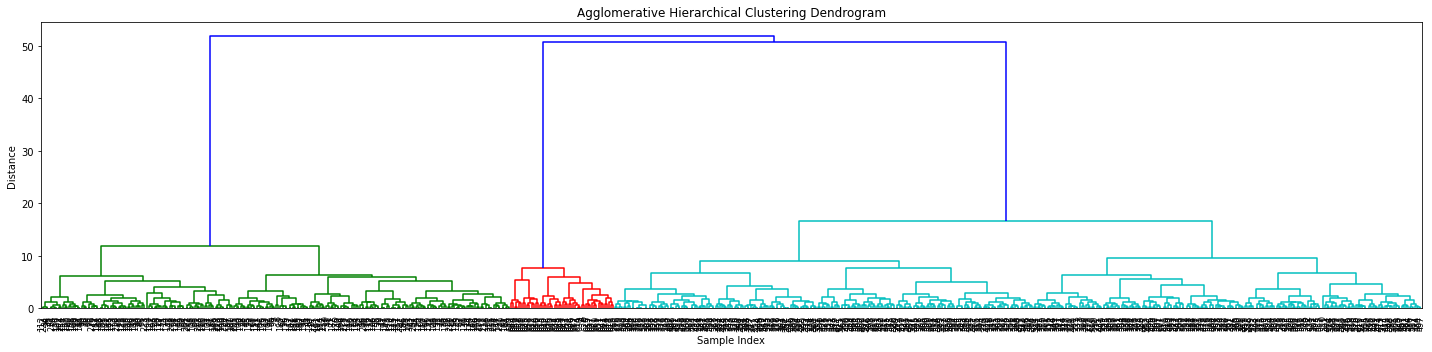

In [39]:
# Dendrogram

plt.figure(figsize = (20, 5))
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90, color_threshold = 40, leaf_font_size = 8)
plt.tight_layout()

In [40]:
# Comparing dendrograms

coph = {'Cophenetic Correlation': [c_average, c_complete, c_ward]}
comp_dendro = pd.DataFrame(coph, index=['Average', 'Complete', 'Ward'])

comp_dendro

,Cophenetic Correlation
Average,0.904864
Complete,0.886052
Ward,0.774234


array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[CLUSTER]'>],
       [<AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[CLUSTER]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[CLUSTER]'>,
        <AxesSubplot:>]], dtype=object)

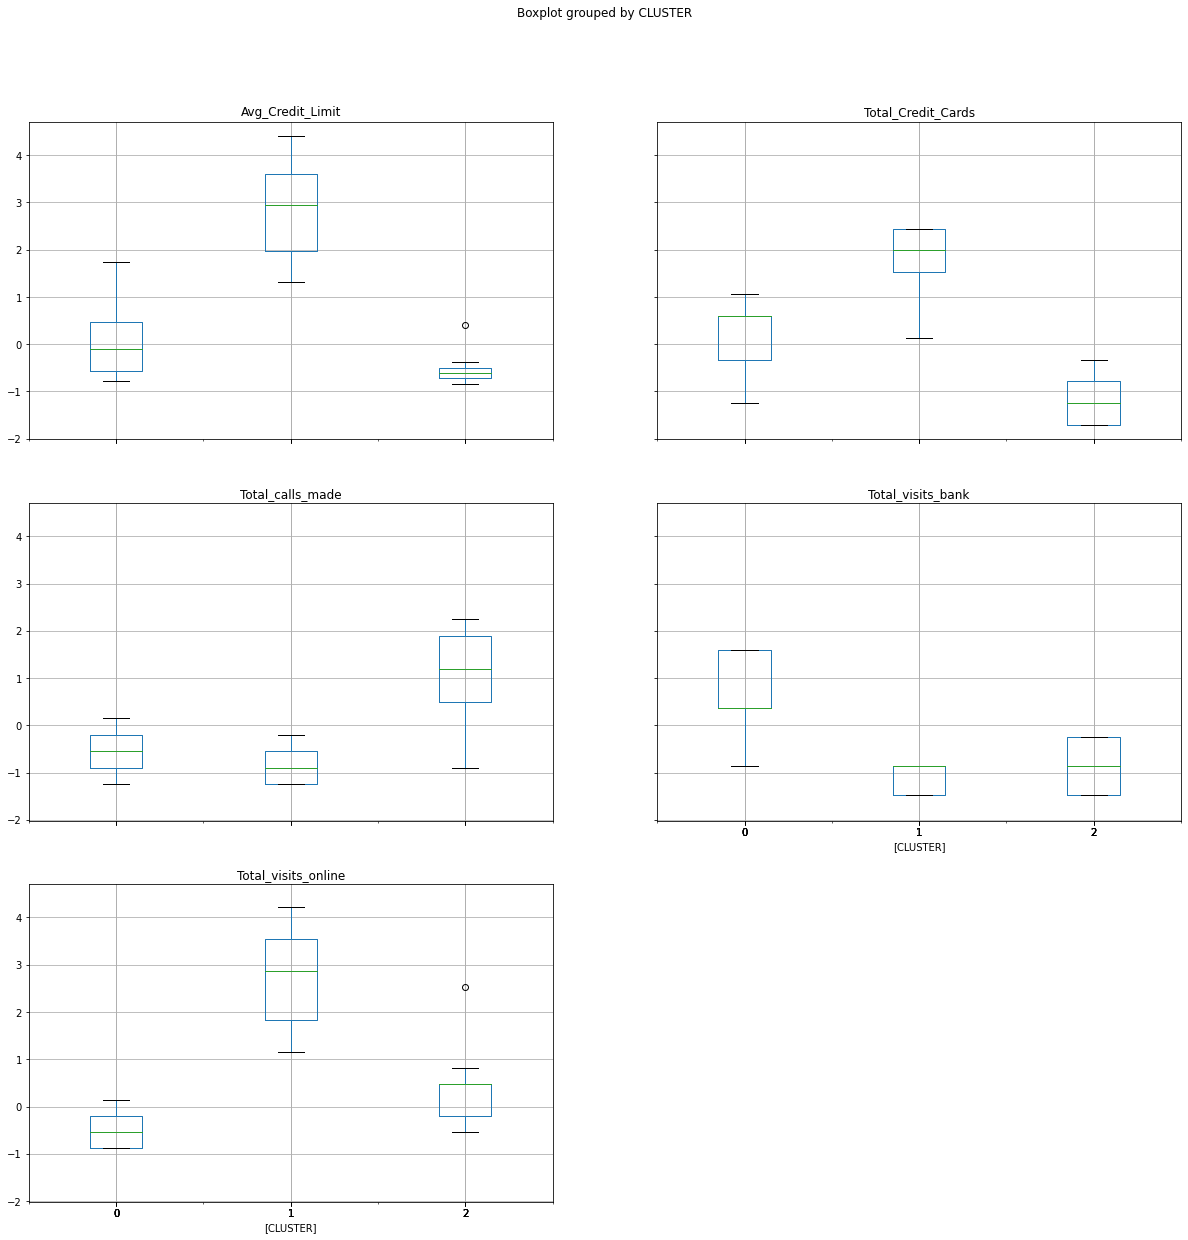

In [41]:
data_agg.boxplot(by = 'CLUSTER', figsize = (20, 20))

In [42]:
# Silhouette score for K-Means

X = data.loc[:, data.columns != 'CLUSTER']

for n_clusters in range(2, 6):
    model = KMeans(n_clusters)
    model.fit(data)
    pred = model.predict(data)
    silhouette_avg_k = silhouette_score(X, pred)
    print("For n_clusters =", n_clusters, "the average silhouette score is: ", silhouette_avg_k)

For n_clusters = 2 the average silhouette score is:  0.4193390769907347
For n_clusters = 3 the average silhouette score is:  0.5157182558881063
For n_clusters = 4 the average silhouette score is:  0.3557860871310981
For n_clusters = 5 the average silhouette score is:  0.2717470361089752


In [43]:
# Silhouette score for Hierarchical

X = data_agg.loc[:, data.columns != 'CLUSTER']

for n_clusters in range(2, 6):
    model = AgglomerativeClustering(n_clusters)
    pred = model.fit_predict(data_agg)
    silhouette_avg_agg = silhouette_score(X, pred)
    print("For n_clusters =", n_clusters, "the average silhouette score is: ", silhouette_avg_agg)

For n_clusters = 2 the average silhouette score is:  0.41842496663215445
For n_clusters = 3 the average silhouette score is:  0.5157182558881063
For n_clusters = 4 the average silhouette score is:  0.34735760548506467
For n_clusters = 5 the average silhouette score is:  0.25505474901117214


### The average silhouette score is highest (0.51) with 3 clusters for both K-Means and Hierarchical Clustering, indicating cluster formation is best at this number of clusters.

### Answers to the key questions:

1. How many different segments of customers are there?

   There are **three** customer segments, according to the clustering.
    
    
2. How are these segments different from each other?
    
    **Cluster 0**: Average credit limits are around average for the entire customer base, total calls and total online visits are below average, total number of credit cards is average, and in-person visits to the bank are above average.
    
    **Cluster 1**: Average credit limits are significantly higher than average, total calls made is below average, total online visits significantly above average, total credit cards above average, but total in-person bank visits below average.
    
    **Cluster 2**: Average credit limits below average, total calls made much higher than average of entire customer base, total visits online are around average, and total credit cards and in-person visits to the bank are well below average.


3. What are your recommendations to the bank on how to market to and better service these customers?

   According to the background information for the project, "the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the [bank] poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster."
   
   Therefore, analyzing the clusters formed using Hierarchical Clustering, we can surmise that the marketing team could target the customers in Cluster 0 with ads encouraging them to take advantage of their online and over-the-phone services more frequently, which would likely result in queries being resolved more quickly. The customers in Cluster 1 are already utilizing the bank's online services in much higher numbers than the rest of the customer base, but they could be targeted with ads that demonstrate how using over-the-phone banking might prove advantageous to them. It might be a good idea for the marketing team to target Cluster 2 with ads for their online services, since the total visits online for that cluster are around average, and thus could be improved.